In [1]:
# Change directory to the root of the project
import os 
os.chdir('..')
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/eohjelle/Documents/2025-dots-and-boxes/dots-and-boxes


In this notebook we'll inspect a pretrained model.

In [2]:
from applications.tic_tac_toe.experimental_transformer import TicTacToeExperimentalTransformer
from core import ModelInterface

M = ModelInterface.from_wandb(
    model_architecture=TicTacToeExperimentalTransformer,
    project='AlphaZero-TicTacToe',
    model_name='experimental_transformer_model',
)

model = M.model

wandb:   1 of 1 files downloaded.  
/Users/eohjelle/Documents/2025-dots-and-boxes/dots-and-boxes/core/model_interface.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch

In [3]:
print(model)

TicTacToeExperimentalTransformer(
  (input_embedding): Embedding(3, 32)
  (attn): MaskedSimAttn(
    (q_emb): Linear(in_features=32, out_features=32, bias=False)
    (k_emb): Linear(in_features=32, out_features=32, bias=False)
    (v_emb): Linear(in_features=32, out_features=32, bias=False)
    (out_emb): Linear(in_features=32, out_features=32, bias=True)
  )
)


Note that `attn.mask` is not shown here. I guess parameters directly registered with `nn.Parameter` are not displayed in the default string representation.

# The attention mask

I want to look at the `attn.mask` parameter to see what kind of patterns it is masking. The expectation is that it will learn patterns that are useful for the game, such as lines (horizontal, diagonal, vertical) where 3 in a row can be drawn.

In [4]:
# Specifically inspect the attn.mask parameter
mask = model.attn.mask
print(f"Shape: {mask.shape}")

Shape: torch.Size([4, 9, 9])


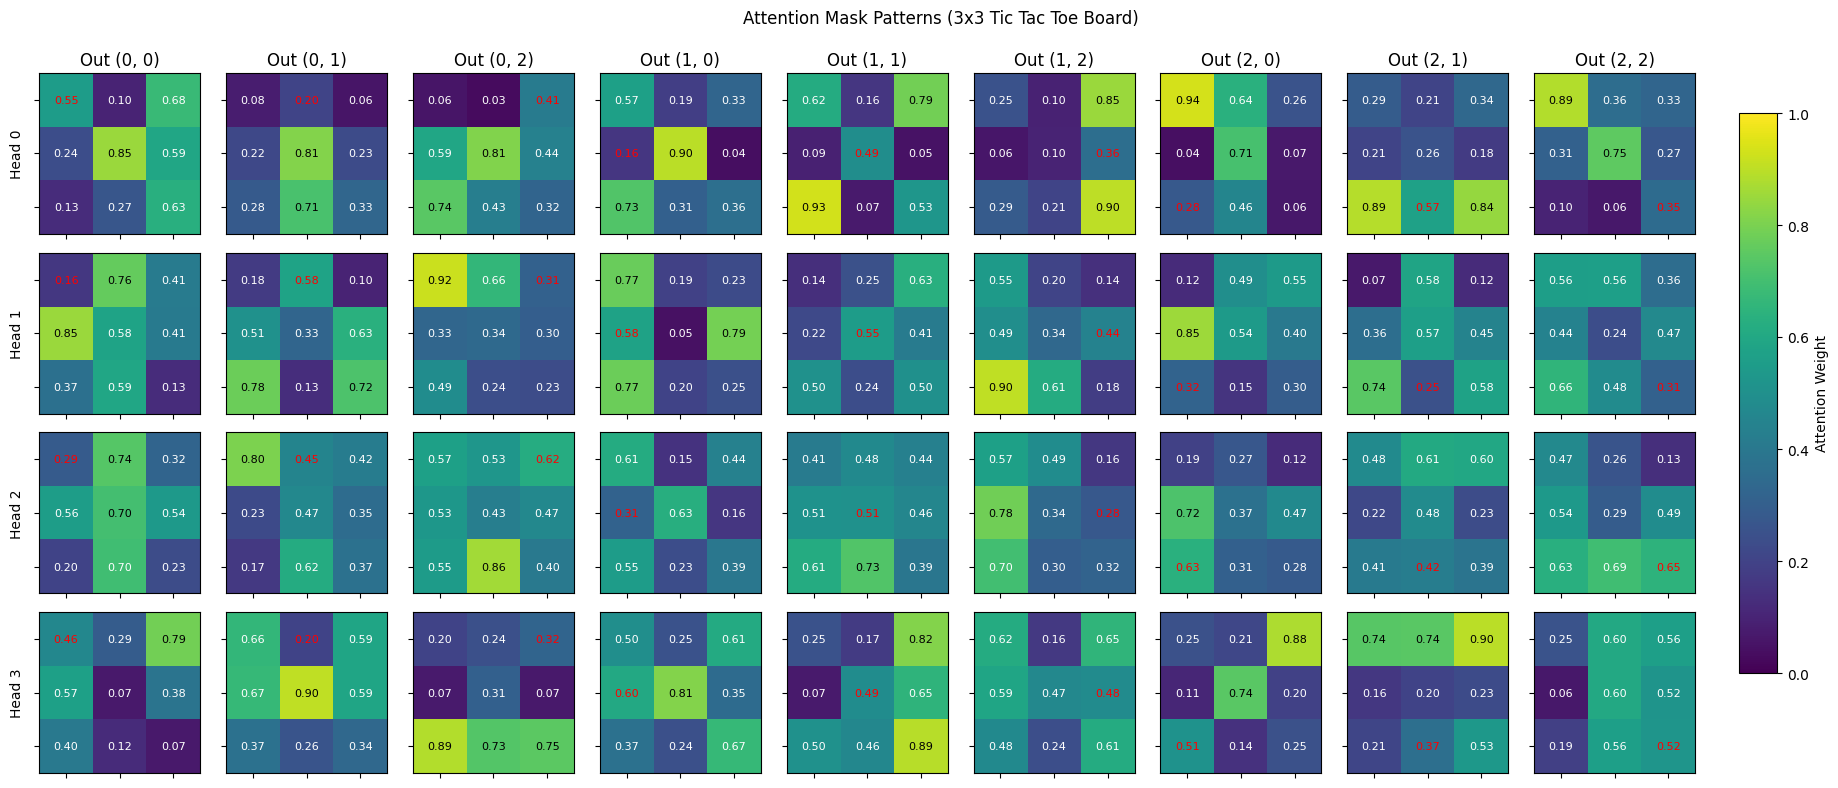

/var/folders/22/9ys3dbcs5yb0wn1j_xcbb4600000gn/T/ipykernel_56617/3645066419.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


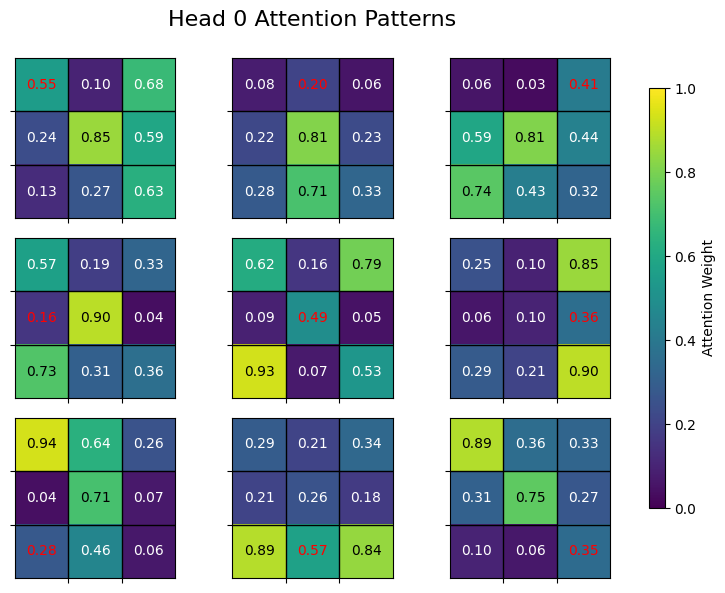

/var/folders/22/9ys3dbcs5yb0wn1j_xcbb4600000gn/T/ipykernel_56617/3645066419.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


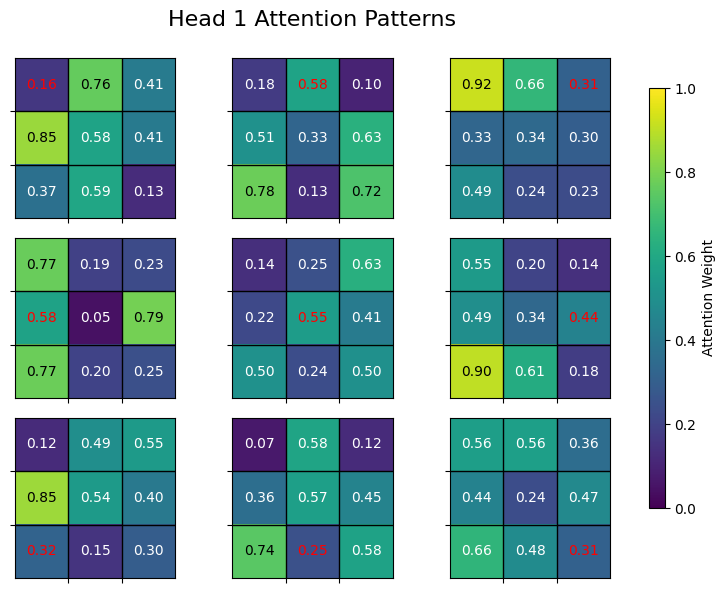

/var/folders/22/9ys3dbcs5yb0wn1j_xcbb4600000gn/T/ipykernel_56617/3645066419.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


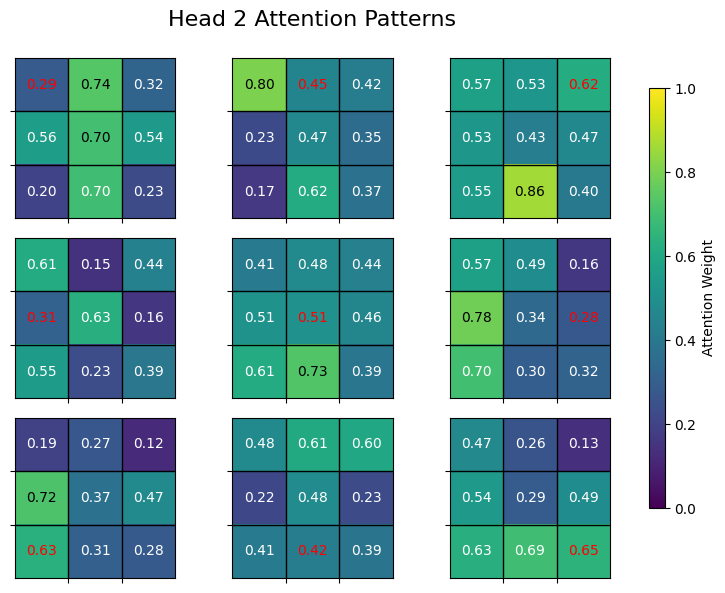

/var/folders/22/9ys3dbcs5yb0wn1j_xcbb4600000gn/T/ipykernel_56617/3645066419.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


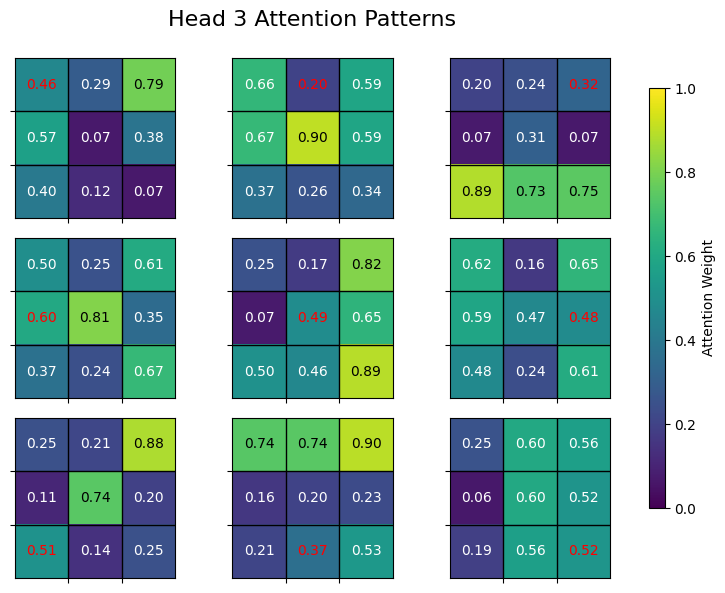

In [20]:
# Display mask as a grid of heatmaps
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the mask and convert to numpy
mask = model.attn.mask
gate = (torch.tanh(mask) + 1)/2  # Apply the same transformation as in forward pass
mask_np = gate.detach().cpu().numpy()

num_heads = mask_np.shape[0]
output_seq_len = mask_np.shape[1]
input_seq_len = mask_np.shape[2]

# Create a figure with subplots for each head
fig, axes = plt.subplots(num_heads, output_seq_len, 
                         figsize=(output_seq_len*2 + 1, num_heads*2),
                         squeeze=False)

# For Tic Tac Toe, reshape each 9-element vector into a 3x3 grid
for head_idx in range(num_heads):
    for output_idx in range(output_seq_len):
        row = output_idx // 3
        col = output_idx % 3
        
        ax = axes[head_idx, output_idx]
        
        # Get the mask values for this head and output token
        # and reshape into a 3x3 grid
        mask_values = mask_np[head_idx, output_idx].reshape(3, 3)
        
        # Plot as a heatmap
        im = ax.imshow(mask_values, cmap='viridis', vmin=0, vmax=1)
        
        # Add text annotations with the values
        for i in range(3):
            for j in range(3):
                if i == row and j == col:
                    text_color = 'red'
                else:
                    text_color = 'white' if mask_values[i, j] < 0.7 else 'black'
                ax.text(j, i, f'{mask_values[i, j]:.2f}', 
                        ha='center', va='center', color=text_color, fontsize=8)
        
        # Set title for each subplot
        if head_idx == 0:
            ax.set_title(f'Out {row, col}')
        if output_idx == 0:
            ax.set_ylabel(f'Head {head_idx}')
            
        # Remove ticks but keep grid lines
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0, 1, 2])
        ax.set_xticklabels([])
        ax.set_yticklabels([])


plt.tight_layout()
plt.subplots_adjust(right=0.9)

# Add a colorbar to the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Attention Weight')

plt.suptitle('Attention Mask Patterns (3x3 Tic Tac Toe Board)')
plt.subplots_adjust(top=0.9)
plt.show()

# Alternative visualization: One large figure per head
for head_idx in range(num_heads):
    fig, axes = plt.subplots(3, 3, figsize=(8, 6))
    plt.suptitle(f'Head {head_idx} Attention Patterns', fontsize=16)
    
    for output_idx in range(output_seq_len):
        # Calculate row and column in the 3x3 grid
        row = output_idx // 3
        col = output_idx % 3
        
        ax = axes[row, col]
        
        # Get the mask values for this head and output token
        # and reshape into a 3x3 grid for visualization
        mask_values = mask_np[head_idx, output_idx].reshape(3, 3)
        
        # Plot as a heatmap
        im = ax.imshow(mask_values, cmap='viridis', vmin=0, vmax=1)
        
        # Add text annotations with the values
        for i in range(3):
            for j in range(3):
                if i == row and j == col:
                    text_color = 'red'
                else:
                    text_color = 'white' if mask_values[i, j] < 0.7 else 'black'
                ax.text(j, i, f'{mask_values[i, j]:.2f}', 
                        ha='center', va='center', color=text_color)
        
        # Set title for each subplot
        # ax.set_title(f'Output Position {output_idx}')
        
        # Add grid lines
        ax.set_xticks([0.5, 1.5])
        ax.set_yticks([0.5, 1.5])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, color='black', linestyle='-', linewidth=1)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.99, hspace=0.4)

    # Add a colorbar to the right side of the figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Attention Weight')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()